# Loan Recommendation System
## POC - Proof Of Concept

<img src="ClusterSchema.png" />

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, count #countDistinct
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors  ##DenseMatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import time

In [2]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "12g").getOrCreate()

In [3]:
# loans_df = spark.read.csv("RecommendData/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df = spark.read.csv("Loan_Dataset/df_temp_cluster_Own_Loan_Amount_Condition.csv", inferSchema=True, header=True)

loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)



In [4]:
loans_df.select(["Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).describe().show(10)

+-------+------------------+-----------------+-------------------+--------------------+------------------+
|summary|    Cluster_result|           Amount|Total_Repayments__c|Payment_Frequency__c|             count|
+-------+------------------+-----------------+-------------------+--------------------+------------------+
|  count|            481071|           481071|             481071|              481071|            481071|
|   mean|11.568618769370842|861.5759420127174|  7.075398433911003|                NULL|1.6787376499518782|
| stddev| 8.303280980759853|809.0576736930908|   4.13654303900754|                NULL|0.8991013265350597|
|    min|                 1|              100|                  1|         Fortnightly|                 0|
|    max|                38|             5000|                 45|              Weekly|                 8|
+-------+------------------+-----------------+-------------------+--------------------+------------------+



- Id: Likely a unique identifier for each data point.
- AccountID: Unique identifier for an account (possibly borrower).
- <h4>Loan-related features: </h4>
    -> Number_Of_Loans_Granted__c: Number of loans granted to the account.
    -> Num_Of_Loans_Paid__c: Number of loans paid by the account.
    -> Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    -> Total_Repayments__c: Total amount repaid by the account.
    -> Amount: Loan amount requested.
    -> Term_in_Weeks__c: Loan term in weeks.
    -> Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
- <h4>Borrower-related features: </h4>
    ->
StageName: Current stage of the loan application (e.g., application, approved, rejected).    ->
Applicant Age: Age of the loan applicant    -> .
summary_income: Summary of applicant's incom    -> e.
summary_income_cv: Coefficient of variation of applicant's inco- <h4>me.
Location-related feat </h4>u    -> res:
city: City of the appli    -> cant.
state: State of the appl    -> icant.
Country: Country of the ap

- <h4>Additional features:</h4>
    ->
userId: Unique identifier for a user Account Id in Numericr).    ->
loanId: Unique identifier for a lo (Id or loanId in Numeric)an    -> .
counFeature related to the Ratings of the Loansnt    -> s.
LoanIdFormat: Format of the loan(Created LoanId using Clusters)nce).plicant.

In [5]:
loans_df.select(["Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+--------------+------+-------------------+--------------------+-----+
|Cluster_result|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+--------------+------+-------------------+--------------------+-----+
|             1|   150|                  6|              Weekly|    1|
|             1|   100|                  3|         Fortnightly|    1|
|             1|   100|                  6|         Fortnightly|    1|
|             1|   100|                  5|         Fortnightly|    1|
|             1|   100|                  6|              Weekly|    1|
|             1|   100|                  3|         Fortnightly|    1|
|             1|   150|                  3|         Fortnightly|    1|
|             1|   100|                  6|              Weekly|    1|
|             1|   100|                 10|              Weekly|    1|
|             1|   100|                 10|              Weekly|    1|
+--------------+------+-------------------+--------------------+-----+
only s

### Removing the outliers point created by the DBSCAN Clustering Algorithm

In [6]:
loans_df =  loans_df.filter(loans_df.Cluster_result != -1)

In [7]:
loans_df.filter(loans_df.Cluster_result == -1).select("Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count").show(50)

+--------------+------+-------------------+--------------------+-----+
|Cluster_result|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+--------------+------+-------------------+--------------------+-----+
+--------------+------+-------------------+--------------------+-----+



### Aggregating the loans per user (getting all loans for each user user)

In [8]:
user_loans = loans_df.groupby("userId").agg(F.collect_set("Cluster_result").alias("loans"))

In [9]:
Actual_loans_taken = user_loans.toPandas().to_dict('records')

### EDA - Exploratory Data Analysis 

<img src="https://editor.analyticsvidhya.com/uploads/24537Zoom-EDA.png" height=500 width="500" />

In [10]:
loans_df.select(["userId","Cluster_result","count","Amount","Total_Repayments__c","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|summary|            userId|    Cluster_result|             count|           Amount|Total_Repayments__c|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|  count|            481071|            481071|            481071|           481071|             481071|                    481071|              481071|
|   mean|24326.531557711856|11.568618769370842|1.6787376499518782|861.5759420127174|  7.075398433911003|        11.976535688079306|  11.937926002606684|
| stddev| 15297.49656622274| 8.303280980759853|0.8991013265350597|809.0576736930908|   4.13654303900754|         8.181979971617142|   8.305027934063407|
|    min|                 1|                 1|                 0|              10

#### Plotting the Frequnecy of Count(Ratings)

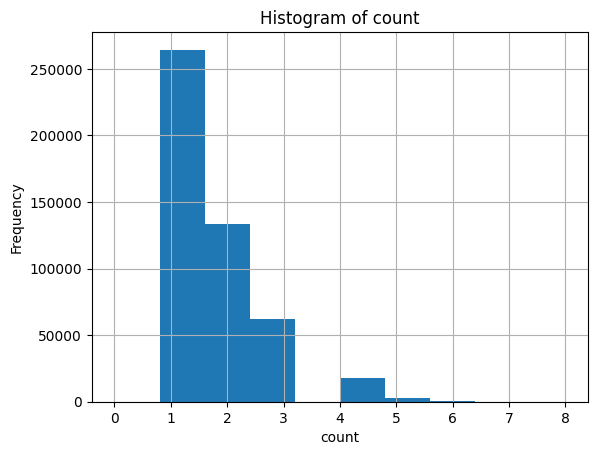

In [11]:
hist_data  = loans_df.toPandas()

hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

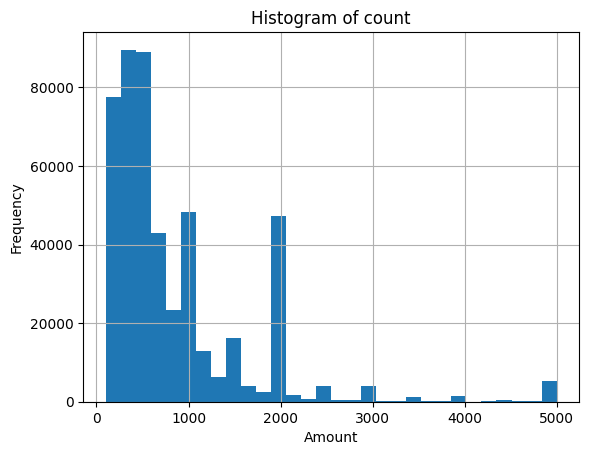

In [12]:
hist_data['Amount'].hist(bins=30)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

#### Counting the No. of user & No. of Loans & No. of Explicitely Created Loan Id (Clustered Loan Id's)

In [13]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('Cluster_result').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 38
Number of unique Loan Id: 407389


In [14]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

Number of unique users: 59158


#### Values of count(Rating) Column.

In [15]:
print('Distinct values of count:')
loans_df.select('count').distinct().orderBy("count").show()

Distinct values of count:
+-----+
|count|
+-----+
|    0|
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
+-----+



### Converting the dataset into train test and validation split.

In [16]:
# we have to use 3 columns or features to put into the ALs Model.
loans_df.select(["Cluster_result","count","Amount"]).show(10)

+--------------+-----+------+
|Cluster_result|count|Amount|
+--------------+-----+------+
|             1|    1|   150|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   150|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   100|
+--------------+-----+------+
only showing top 10 rows



In [17]:
train, validation = loans_df.randomSplit([0.8, 0.2])
# train, validation, test = loans_df.randomSplit([0.8, 0.1, 0.1])
# # cache data
train.cache()
validation.cache()
# test.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, Cluster_result: int]

In [18]:
validation.select(["userId","loanId","Cluster_result","count","Amount","Total_Repayments__c"]).show()

+------+------+--------------+-----+------+-------------------+
|userId|loanId|Cluster_result|count|Amount|Total_Repayments__c|
+------+------+--------------+-----+------+-------------------+
|   149|    29|             2|    1|   200|                 10|
| 24479|    71|             2|    2|   200|                  2|
|   181|    81|             2|    3|   200|                  5|
|   183|    93|             4|    4|   300|                  5|
| 25272|   123|             4|    4|   300|                  4|
|    11|   128|             2|    3|   200|                  4|
| 24343|   140|             4|    1|   300|                  2|
|    21|   153|             5|    2|   350|                  4|
|    25|   160|             4|    1|   300|                  4|
|    33|   171|             4|    1|   300|                  4|
| 23640|   189|             2|    1|   200|                  5|
| 25421|   193|             2|    3|   200|                  5|
| 24715|   205|             4|    2|   3

In [19]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)



In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [23]:
# Step 1: Define the ALS model
als = ALS(userCol='userId', itemCol='Cluster_result', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
# als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

# Step 2: Define the pipeline
pipeline = Pipeline(stages=[als])


# Step 3: Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(als.rank,  [8, 10, 20, 30, 40, 60]) \
    .addGrid(als.regParam, [0.001, 0.01, 0.05, 0.1, 0.2]) \
    .build()

# Step 4: Define the evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")

# Step 5: Define the CrossValidator
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=10)

# Step 6: Fit the CrossValidator on the training data
cv_model = cross_validator.fit(train)

# Step 7: Make predictions on the test data
predictions = cv_model.transform(validation)

# Step 8: Evaluate the model using RMSE
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.035893933551779986


In [ ]:
final_model.save("Recommendation_ALS_Model_OWN_LOAN_CLUSTER_STRATEGY")

## Predicting the results from validation data

In [25]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [26]:
predictions.filter(predictions.userId == 10).select("userId", "loanId", "count", "Cluster_result", "prediction").show(20)

+------+------+-----+--------------+----------+
|userId|loanId|count|Cluster_result|prediction|
+------+------+-----+--------------+----------+
|    10|   127|    4|             2| 3.9131937|
|    10|  2535|    4|             2| 3.9131937|
|    10|  4994|    4|             4| 3.9433255|
|    10|137071|    4|             4| 3.9433255|
|    10|150192|    4|             3| 3.9256163|
|    10|196969|    4|             2| 3.9131937|
|    10| 12340|    4|             6|  3.967088|
|    10| 32216|    4|             8| 3.9780626|
|    10|248485|    4|             8| 3.9780626|
|    10| 42894|    4|            12| 4.0086994|
+------+------+-----+--------------+----------+



## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [27]:
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))

Root Mean Squared Error (RMSE) = 0.03137979806564294


## Recommendation of N users

In [28]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [29]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Cluster_result: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [30]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)



In [31]:
validation.count()

96643

## ALS Model Evaluation

In [32]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['userId', 'Cluster_result'], 'inner')

In [33]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('userId').agg(expr('count(Cluster_result) as true_positives'))

In [34]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('userId').agg(expr('count(Cluster_result) as relevant'))

In [35]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as precision')

In [36]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as recall')

In [37]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'userId', 'inner') \
    .selectExpr('userId', '(2 * precision * recall) / (precision + recall) as f1_score')

In [38]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [39]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 1.2880390991044623
Overall Recall: 1.2880390991044623
Overall F1-score: 1.2880390991044612


In [40]:
evaluator = RegressionEvaluator(metricName="mae", labelCol="count", predictionCol="prediction")
mae = evaluator.evaluate(predictions)

In [41]:
"The Mean Absolute Error is :",mae

('The Mean Absolute Error is :', 0.022825613020757824)

## User Factors and Item Factors to calculate the cosine Similarity

In [42]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [43]:
print(userFactors.count())
print("Priting the Schema of userFactors",userFactors.printSchema())

58832
root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

Priting the Schema of userFactors None


In [44]:
userFactors.select("id","features").sort("id").show(10,truncate=False)

+---+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                                                                                       

In [45]:
itemFactors.select("id","features").sort("id").show(10,truncate=False)

+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                                                                  

In [46]:
final_model.userFactors.orderBy("id").collect()

[Row(id=1, features=[0.0579008050262928, 0.7453485727310181, 0.4325849115848541, 0.02149149961769581, 0.2980569005012512, 0.6020584106445312, 0.1795843243598938, 0.24242110550403595, 0.2848879098892212, 0.5032815933227539, 0.015966515988111496, 0.016949260607361794, 0.4531986713409424, 0.4850935637950897, 0.4013615846633911, 0.27122360467910767, 1.3233764171600342, 0.10845530778169632, 0.39910829067230225, 0.09176547825336456, 0.44947904348373413, 0.9645544290542603, 0.385804682970047, 0.21184800565242767, 0.06753510236740112, 0.0, 0.07510291785001755, 5.847768534295028e-06, 0.5267996191978455, 0.0, 0.06257189810276031, 0.12663649022579193, 0.6451259255409241, 0.38467341661453247, 0.6643150448799133, 0.4852272868156433, 0.1939653605222702, 0.036691538989543915, 0.13115376234054565, 0.28440791368484497, 0.08719334751367569, 0.3627442419528961, 0.12929821014404297, 0.683048665523529, 0.5033275485038757, 0.1207970604300499, 0.6504725217819214, 0.0, 1.0322145223617554, 0.000857941398862749

In [47]:
userFactors.select(["id","Features"]).show(10,truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |Features                                                                                                                                                                                                                                             

## Calculate cosine similarity:

### user-User Cosine Similarity code

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [48]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

In [49]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Cosine similarity between users 10 and 20: 0.9979420048061138


### User-Item Cosine Similarity code

In [50]:
# Example usage
user1_id = 10
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")

Cosine similarity between users 10 and 1: 0.9924888298401526


###  Cosine Similarity of user 10 with all Loans

In [51]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [52]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 10, 'LoanId': 3, 'CosineSimilarity': 0.9999867070854686},
 {'userID': 10, 'LoanId': 4, 'CosineSimilarity': 0.9998156948845781},
 {'userID': 10, 'LoanId': 5, 'CosineSimilarity': 0.9996814326947069},
 {'userID': 10, 'LoanId': 2, 'CosineSimilarity': 0.9996760993427464},
 {'userID': 10, 'LoanId': 7, 'CosineSimilarity': 0.9984618451604321},
 {'userID': 10, 'LoanId': 6, 'CosineSimilarity': 0.9981264894606087},
 {'userID': 10, 'LoanId': 8, 'CosineSimilarity': 0.997942004939733},
 {'userID': 10, 'LoanId': 9, 'CosineSimilarity': 0.9961673507718762},
 {'userID': 10, 'LoanId': 25, 'CosineSimilarity': 0.9942626029948445},
 {'userID': 10, 'LoanId': 11, 'CosineSimilarity': 0.9937331062735268},
 {'userID': 10, 'LoanId': 10, 'CosineSimilarity': 0.9931621103375429},
 {'userID': 10, 'LoanId': 12, 'CosineSimilarity': 0.9926674872275162},
 {'userID': 10, 'LoanId': 1, 'CosineSimilarity': 0.9924888298401526},
 {'userID': 10, 'LoanId': 14, 'CosineSimilarity': 0.9910853861522451},
 {'userID': 10, 

### Cosine Similarity of all users with all loans

In [53]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [54]:
# Initially the code is like this !!
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

def cosine_similarity(vec1, vec2):
    dot_product = sum(v1 * v2 for v1, v2 in zip(vec1, vec2))
    magnitude1 = sum(v ** 2 for v in vec1) ** 0.5
    magnitude2 = sum(v ** 2 for v in vec2) ** 0.5
    return dot_product / (magnitude1 * magnitude2)

In [55]:


# Initialize list to store recommendations
CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.004619852238231235 hours


In [56]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_recommendations = extract_top_n_recommendations(CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [57]:
top_n_recommendations

[{'userId': 1, 'Recommendation': [14, 12, 13, 10, 16]},
 {'userId': 2, 'Recommendation': [8, 6, 9, 7, 25]},
 {'userId': 3, 'Recommendation': [6, 8, 7, 9, 5]},
 {'userId': 4, 'Recommendation': [3, 2, 4, 5, 7]},
 {'userId': 5, 'Recommendation': [6, 8, 7, 9, 5]},
 {'userId': 6, 'Recommendation': [8, 6, 7, 9, 5]},
 {'userId': 7, 'Recommendation': [9, 25, 11, 10, 12]},
 {'userId': 8, 'Recommendation': [13, 14, 12, 16, 15]},
 {'userId': 9, 'Recommendation': [6, 7, 8, 9, 5]},
 {'userId': 10, 'Recommendation': [3, 4, 5, 2, 7]},
 {'userId': 11, 'Recommendation': [3, 4, 5, 2, 7]},
 {'userId': 12, 'Recommendation': [4, 5, 3, 7, 6]},
 {'userId': 13, 'Recommendation': [5, 4, 7, 6, 8]},
 {'userId': 14, 'Recommendation': [13, 14, 16, 12, 15]},
 {'userId': 15, 'Recommendation': [3, 4, 5, 2, 7]},
 {'userId': 16, 'Recommendation': [12, 13, 14, 10, 16]},
 {'userId': 17, 'Recommendation': [4, 5, 3, 2, 7]},
 {'userId': 18, 'Recommendation': [4, 5, 3, 7, 6]},
 {'userId': 19, 'Recommendation': [5, 4, 7, 6, 8

In [58]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [81]:
actual_loans_taken_dict

{1: [15, 12, 30, 16, 24, 21, 18, 14, 8],
 3: [6, 10, 25, 4, 8],
 5: [16, 6, 3, 10, 8],
 6: [12, 16, 8],
 9: [6, 7],
 12: [16, 2, 17, 6, 21, 14, 8],
 13: [2, 6, 25, 4, 8],
 15: [5, 2, 6, 3, 10, 25, 4, 8],
 16: [12, 16, 25, 8],
 17: [12, 16, 5, 2, 20, 6, 3, 10, 4, 11, 8],
 19: [16, 2, 18, 10, 4, 14, 8],
 20: [8],
 22: [5, 6, 3],
 26: [18, 10, 8],
 27: [5, 2, 6, 8],
 28: [5, 10, 14, 8],
 31: [30, 16, 24, 3, 18, 21, 10, 4, 14],
 34: [15, 12, 19, 6, 3, 18, 24, 10, 7, 4, 14, 11, 8],
 37: [38, 10, 25, 4, 11, 26, 13, 5, 20, 35, 6, 7, 14, 8, 23],
 40: [16, 10, 14],
 41: [27, 16, 38, 32, 21, 14],
 43: [30, 16, 38, 24, 21, 36, 23],
 44: [6, 25, 8],
 47: [16, 13, 5, 6, 8],
 48: [9, 2, 6, 4, 8],
 52: [12, 3, 10, 25, 8],
 53: [15, 6, 18, 10, 14, 8],
 54: [12, 5, 2, 6, 3, 10, 7, 4, 14, 8],
 57: [15, 6, 21, 18, 10, 25, 14, 8],
 61: [2, 6, 10],
 64: [5, 2, 3],
 65: [15, 2, 6, 10, 8],
 72: [16, 13, 6, 4, 8],
 76: [16, 6, 21, 10, 22, 26],
 78: [13, 2, 10, 4, 8],
 81: [5, 2, 6, 3, 4],
 85: [15, 12, 16, 17

In [59]:
recommendations_for_users

[{'UserId': 1, 'Recommendations': [13, 10, 11, 25, 17]},
 {'UserId': 2, 'Recommendations': [9, 7, 11, 12, 14]},
 {'UserId': 3, 'Recommendations': [7, 9, 5, 11, 3]},
 {'UserId': 4, 'Recommendations': [5, 7, 6, 8, 9]},
 {'UserId': 5, 'Recommendations': [7, 9, 5, 4, 25]},
 {'UserId': 6, 'Recommendations': [6, 7, 9, 5, 4]},
 {'UserId': 7, 'Recommendations': [9, 11, 10, 8, 14]},
 {'UserId': 8, 'Recommendations': [14, 10, 11, 17, 9]},
 {'UserId': 9, 'Recommendations': [8, 9, 5, 4, 25]},
 {'UserId': 10, 'Recommendations': [7, 9, 11, 10, 1]},
 {'UserId': 11, 'Recommendations': [5, 7, 9, 25, 11]},
 {'UserId': 12, 'Recommendations': [4, 5, 3, 7, 9]},
 {'UserId': 13, 'Recommendations': [5, 7, 3, 9, 11]},
 {'UserId': 14, 'Recommendations': [13, 14, 12, 15, 17]},
 {'UserId': 15, 'Recommendations': [7, 9, 11, 12, 1]},
 {'UserId': 16, 'Recommendations': [13, 14, 10, 11, 15]},
 {'UserId': 17, 'Recommendations': [7, 9, 25, 14, 13]},
 {'UserId': 18, 'Recommendations': [4, 5, 3, 7, 9]},
 {'UserId': 19, '

In [90]:
userRecommends.select(["userId","recommendations.Cluster_result","recommendations.rating"]).show(10,truncate=False)

+------+--------------------+-------------------------------------------------------+
|userId|Cluster_result      |rating                                                 |
+------+--------------------+-------------------------------------------------------+
|1     |[38, 37, 35, 36, 34]|[3.0354345, 3.026924, 3.023729, 3.02069, 3.0198197]    |
|6     |[38, 37, 36, 35, 33]|[1.0216187, 1.0194496, 1.0192949, 1.0191927, 1.0183234]|
|12    |[38, 36, 37, 33, 35]|[2.024205, 2.0212004, 2.020596, 2.0203755, 2.0203145]  |
|13    |[38, 36, 33, 37, 35]|[1.0187738, 1.017325, 1.0169692, 1.0169305, 1.0168515] |
|16    |[38, 37, 35, 36, 34]|[1.02128, 1.0183824, 1.0172148, 1.0160935, 1.0160298]  |
|22    |[38, 36, 33, 37, 35]|[1.0218852, 1.020424, 1.0200554, 1.0199949, 1.0199525] |
|26    |[38, 37, 36, 35, 33]|[1.0170398, 1.0148207, 1.0145209, 1.0145079, 1.0133983]|
|27    |[38, 36, 33, 37, 35]|[1.0196977, 1.0185685, 1.0184395, 1.0179611, 1.0179579]|
|28    |[38, 37, 36, 35, 33]|[1.0183209, 1.0162293, 1.

In [60]:
actual = [listo for listo in actual_loans_taken_dict.values()]

In [61]:
predicted = [listo['Recommendation'] for listo in top_n_recommendations]

In [62]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [63]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.1865


In [64]:
userRecomd = userRecommends.select("recommendations.Cluster_result").collect() #.show(10,truncate=False)

In [65]:
ALsRecomd = [elemt.asDict()['Cluster_result'] for elemt in userRecomd]

In [66]:

k = 5
map_at_5 = map_at_k(actual, ALsRecomd, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.0091


##  Calculate centered cosine similarity:

In [67]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [68]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9958091259308894


### User-Item Centerd Cosine Similarity code

In [69]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.9846653141373279


### Centered Cosine Similarity of user 10 with all Loans

In [70]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [71]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 25, 'CenteredSimilarity': 0.9883251622950934},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

In [72]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': 0.9817486250975127},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

## Cosine Similarity of all users with all loans

In [73]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [74]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim

In [75]:
# Initialize list to store recommendations
Centered_CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        Centered_CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.006168066263198852 hours


In [76]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_Centered_recommendations = extract_top_n_recommendations(Centered_CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [77]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in Centered_CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [78]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [79]:
actual = [listo for listo in actual_loans_taken_dict.values()]
predicted = [listo['Recommendation'] for listo in top_n_Centered_recommendations]

In [80]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.1867


In [ ]:
predictions.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [ ]:
predictions.select(["LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction"]).show(11)

+------------+------+------+------+-------------------+-----+----------+
|LoanIdFormat|loanId|userId|Amount|Total_Repayments__c|count|prediction|
+------------+------+------+------+-------------------+-----+----------+
|           1|  1859|  2366|   500|                 10|    1| 0.9933492|
|           1| 18371|  4818|   600|                 10|    2| 1.9914738|
|           1| 24830|  1342|   500|                 10|    1| 0.9981674|
|           1| 39048|  1238|   500|                 10|    3|  2.984103|
|           1| 44319| 19984|   500|                  6|    3|  2.992899|
|           1| 44367| 16503|   300|                  6|    3| 2.9956226|
|           1| 44446| 15846|   200|                  6|    3|  2.991486|
|           1| 48006| 20683|   600|                 10|    1| 0.9933492|
|           1| 49432| 18866|   500|                  6|    1| 0.9981674|
|           1| 50698| 17420|   750|                 10|    1| 0.9965345|
|           1| 51505| 15447|   400|                

In [ ]:
predictions.select("prediction","LoanIdFormat").describe().show()

+-------+------------------+------------------+
|summary|        prediction|      LoanIdFormat|
+-------+------------------+------------------+
|  count|            111352|            111352|
|   mean| 1.661863417419055| 4.518930957683741|
| stddev|0.8937703516935817|2.7881530111682316|
|    min|               0.0|                 1|
|    max|         7.9761477|                20|
+-------+------------------+------------------+



In [ ]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
error = evaluator.evaluate(predictions)

In [ ]:
print(f"The RMSE for the above m0odel is : {error}")  # o.463

The RMSE for the above mnodel is : 0.028842204161434074


In [82]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [83]:
loanRecommends.printSchema()

root
 |-- Cluster_result: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- userId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [85]:
loanRecommends.select(["Cluster_result","recommendations.userId","recommendations.rating"]).show(10,truncate=False)

+--------------+----------------------------------+-----------------------------------------------------+
|Cluster_result|userId                            |rating                                               |
+--------------+----------------------------------+-----------------------------------------------------+
|20            |[1832, 24531, 24495, 1901, 15933] |[8.037345, 7.0303893, 6.9618297, 6.0687914, 6.061984]|
|10            |[1832, 24531, 24495, 1901, 15933] |[7.9840136, 6.9863443, 6.891858, 6.03245, 6.0197334] |
|30            |[1832, 24531, 24495, 15933, 1901] |[8.094451, 7.077286, 7.0510645, 6.109497, 6.108026]  |
|31            |[1832, 24531, 24495, 1901, 15933] |[8.086526, 7.0709996, 7.037193, 6.102946, 6.102759]  |
|1             |[1832, 24531, 24495, 1901, 24301] |[7.656377, 6.719294, 6.5001936, 5.8180833, 5.7863135]|
|21            |[1832, 24531, 24495, 1901, 15933] |[8.04624, 7.036546, 6.982675, 6.07297, 6.069698]     |
|11            |[1832, 24531, 24495, 1901, 159

In [86]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Cluster_result: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [87]:
userRecommends.filter(userRecommends.userId == 10 ).show(vertical=True,truncate=False)

-RECORD 0------------------------------------------------------------------------------------------
 userId          | 10                                                                              
 recommendations | [{38, 4.06807}, {33, 4.0665574}, {36, 4.065596}, {35, 4.06229}, {37, 4.061898}] 



In [89]:
userRecommends.select(["userId","recommendations.Cluster_result","recommendations.rating"]).show(10,truncate=False)

+------+--------------------+-------------------------------------------------------+
|userId|Cluster_result      |rating                                                 |
+------+--------------------+-------------------------------------------------------+
|1     |[38, 37, 35, 36, 34]|[3.0354345, 3.026924, 3.023729, 3.02069, 3.0198197]    |
|6     |[38, 37, 36, 35, 33]|[1.0216187, 1.0194496, 1.0192949, 1.0191927, 1.0183234]|
|12    |[38, 36, 37, 33, 35]|[2.024205, 2.0212004, 2.020596, 2.0203755, 2.0203145]  |
|13    |[38, 36, 33, 37, 35]|[1.0187738, 1.017325, 1.0169692, 1.0169305, 1.0168515] |
|16    |[38, 37, 35, 36, 34]|[1.02128, 1.0183824, 1.0172148, 1.0160935, 1.0160298]  |
|22    |[38, 36, 33, 37, 35]|[1.0218852, 1.020424, 1.0200554, 1.0199949, 1.0199525] |
|26    |[38, 37, 36, 35, 33]|[1.0170398, 1.0148207, 1.0145209, 1.0145079, 1.0133983]|
|27    |[38, 36, 33, 37, 35]|[1.0196977, 1.0185685, 1.0184395, 1.0179611, 1.0179579]|
|28    |[38, 37, 36, 35, 33]|[1.0183209, 1.0162293, 1.

In [ ]:
LoanRecommendation =  [{11, 4.818267}, {19, 4.042764}, {5, 4.033351}, {10, 4.0070896}, {12, 3.9973161}]

In [ ]:
loanRecommend_user_10 = [{"userID":10,"LoanId":loanI,"Ratings":ratin} for loanI,ratin in LoanRecommendation]

In [ ]:
sorted(loanRecommend_user_10, key=operator.itemgetter('Ratings'),reverse=True )

[{'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896}]

In [ ]:
loanRecommend_user_10

[{'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896},
 {'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12}]